In [18]:
# Main
import os
import gc
import shutil
import time
import random
import cv2
import numpy as np 
import pandas as pd
import glob
from tqdm import tqdm
tqdm.pandas()
import re

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp


In [2]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# list_sub = ["ccpd_base", "ccpd_fn", "ccpd_db", "ccpd_rotate", "ccpd_weather", "ccpd_blur"]
list_sub = ["ccpd_weather"]
BASE_PATH = "C:/Users/User/DeepLearning/Deep_Learning/final_project"

In [3]:
# Create Metadata
def extract_plate_number(plate_number):
    chi_let = provinces[int(plate_number.split("_")[0])]
    alp_let = alphabets[int(plate_number.split("_")[1])]
    alp_num_let = plate_number.split("_")[2:]
    alp_num_let = "".join([ads[int(char)] for char in alp_num_let])
    all_let = chi_let + alp_let + alp_num_let
    return all_let
metadata_list = []

# Iterate over subdirectories
for sub in list_sub:
    sub_path = os.path.join(BASE_PATH, sub)
    sub_files = glob.glob(os.path.join(sub_path, "*"))

    # Append a dictionary for each file in the subdirectory
    for file_path in sub_files:
        # Extracting values
        detail = file_path.split("/")[-1].split("-")[2]
        bbox = detail.split("_")[0]
        x1_bbox, y1_bbox = map(int, bbox.split(","))
        x2_bbox, y2_bbox = map(int, detail.split("_")[1].split(","))

      

        # Extracting plate number
        plate_number = file_path.split("-")[4]

        # Create a dictionary for each file
        metadata_dict = {
            "image_path": file_path,
            "sub": sub,
            "x1_bbox": x1_bbox,
            "y1_bbox": y1_bbox,
            "x2_bbox": x2_bbox,
            "y2_bbox": y2_bbox,
            
        }

        # Add more columns to metadata_dict if needed
        metadata_dict["decoded_plate_number"] = extract_plate_number(plate_number)

        # Append the dictionary to the list
        metadata_list.append(metadata_dict)

# Create DataFrame from the list of dictionaries
df_metadata = pd.DataFrame(metadata_list)

# Display the DataFrame
df_metadata = df_metadata[:5500] 
df_metadata

,image_path,sub,x1_bbox,y1_bbox,x2_bbox,y2_bbox,decoded_plate_number
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,294,496,374,540,皖AD130W
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,304,542,411,577,皖AUT267
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,339,547,444,583,皖MZ4882
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,177,511,268,553,皖AVD028
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,402,426,497,467,皖RL222P
...,...,...,...,...,...,...,...
5495,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,96,584,372,688,皖AR8T97
5496,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,265,514,533,621,皖AL6M60
5497,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,282,536,566,637,皖A576X9
5498,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,64,606,309,723,皖ALF155


In [4]:
df_metadata['xmid'] = (df_metadata['x1_bbox'] + df_metadata['x2_bbox']) / (2*720)
df_metadata['ymid'] = (df_metadata['y1_bbox'] + df_metadata['y2_bbox']) / (2*1160)

df_metadata['bb_width'] = (df_metadata['x2_bbox'] - df_metadata['x1_bbox']) / 720
df_metadata['bb_height'] = (df_metadata['y2_bbox'] - df_metadata['y1_bbox']) / 1160

df_metadata

,image_path,sub,x1_bbox,y1_bbox,x2_bbox,y2_bbox,decoded_plate_number,xmid,ymid,bb_width,bb_height
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,294,496,374,540,皖AD130W,0.463889,0.446552,0.111111,0.037931
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,304,542,411,577,皖AUT267,0.496528,0.482328,0.148611,0.030172
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,339,547,444,583,皖MZ4882,0.543750,0.487069,0.145833,0.031034
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,177,511,268,553,皖AVD028,0.309028,0.458621,0.126389,0.036207
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,402,426,497,467,皖RL222P,0.624306,0.384914,0.131944,0.035345
...,...,...,...,...,...,...,...,...,...,...,...
5495,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,96,584,372,688,皖AR8T97,0.325000,0.548276,0.383333,0.089655
5496,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,265,514,533,621,皖AL6M60,0.554167,0.489224,0.372222,0.092241
5497,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,282,536,566,637,皖A576X9,0.588889,0.505603,0.394444,0.087069
5498,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,64,606,309,723,皖ALF155,0.259028,0.572845,0.340278,0.100862


In [5]:
# Train : 5000 (ccpd_base), Val and Test : 50 for each sub (except ccpd_base)
list_split = ["train"] * 5000
for i in range(5):
    list_split.extend(["val"]*50)
    list_split.extend(["test"]*50)
df_metadata["split"] = list_split
df_metadata

,image_path,sub,x1_bbox,y1_bbox,x2_bbox,y2_bbox,decoded_plate_number,xmid,ymid,bb_width,bb_height,split
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,294,496,374,540,皖AD130W,0.463889,0.446552,0.111111,0.037931,train
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,304,542,411,577,皖AUT267,0.496528,0.482328,0.148611,0.030172,train
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,339,547,444,583,皖MZ4882,0.543750,0.487069,0.145833,0.031034,train
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,177,511,268,553,皖AVD028,0.309028,0.458621,0.126389,0.036207,train
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,402,426,497,467,皖RL222P,0.624306,0.384914,0.131944,0.035345,train
...,...,...,...,...,...,...,...,...,...,...,...,...
5495,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,96,584,372,688,皖AR8T97,0.325000,0.548276,0.383333,0.089655,test
5496,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,265,514,533,621,皖AL6M60,0.554167,0.489224,0.372222,0.092241,test
5497,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,282,536,566,637,皖A576X9,0.588889,0.505603,0.394444,0.087069,test
5498,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,64,606,309,723,皖ALF155,0.259028,0.572845,0.340278,0.100862,test


In [7]:
from numba import cuda
from GPUtil import showUtilization as gpu_usage

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


In [8]:
from ultralytics import YOLO
df_results = df_metadata[df_metadata["split"]=="test"].reset_index(drop=True)
df_results = df_results[["image_path", "sub", "decoded_plate_number", "x1_bbox", "y1_bbox", "x2_bbox", "y2_bbox"]]
df_results

,image_path,sub,decoded_plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,鄂AT2W80,176,497,455,595
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AB967N,213,444,469,551
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A25T29,257,384,525,486
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZW108,201,476,493,570
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZ2744,252,586,532,684
...,...,...,...,...,...,...,...
245,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AR8T97,96,584,372,688
246,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AL6M60,265,514,533,621
247,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A576X9,282,536,566,637
248,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖ALF155,64,606,309,723


In [9]:
# Assuming you have already imported your YOLO class

# Instantiate the YOLO model
yolo_model = YOLO('C:/Users/User/runs/detect/train4/weights/best.pt')

# Move the model to CPU
yolo_model = yolo_model.to('cpu')

# Rest of your code remains the same
bbox_results = yolo_model.predict(list(df_results["image_path"]), verbose=False)
all_box_list = []
all_conf_list = []

for bbox_result in bbox_results:
    boxes = bbox_result.boxes
    box_list = []
    conf_list = []

    for box in boxes:
        box_data = box.data[0][:4]
        box_data = [int(x) for x in box_data]
        conf = round(float(box.conf), 2)

        if conf >= 0.5:
            box_list.append(box_data)
            conf_list.append(conf)

    all_box_list.append(box_list)
    all_conf_list.append(conf_list)

df_results["pred_bbox"] = all_box_list
df_results["confidence"] = all_conf_list
df_results


,image_path,sub,decoded_plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox,pred_bbox,confidence
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,鄂AT2W80,176,497,455,595,"[[177, 493, 454, 597]]",[0.94]
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AB967N,213,444,469,551,"[[212, 443, 469, 551]]",[0.94]
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A25T29,257,384,525,486,"[[255, 385, 523, 487]]",[0.93]
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZW108,201,476,493,570,"[[198, 476, 490, 570]]",[0.93]
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZ2744,252,586,532,684,"[[255, 587, 529, 680]]",[0.95]
...,...,...,...,...,...,...,...,...,...
245,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AR8T97,96,584,372,688,"[[95, 584, 372, 687]]",[0.93]
246,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AL6M60,265,514,533,621,"[[268, 515, 530, 620]]",[0.95]
247,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A576X9,282,536,566,637,"[[277, 534, 570, 638]]",[0.92]
248,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖ALF155,64,606,309,723,"[[62, 606, 307, 721]]",[0.94]


In [10]:
resnet = resnet18(pretrained=True)

c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
data_path = "C:/Users/User/DeepLearning/Deep_Learning/final_project/samples"

In [14]:
image_fns = os.listdir(data_path)
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

1071
[5 7]


In [15]:
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0]) != 5:
           print(idx, image_fn)

923 samples


In [16]:
image_fns.remove('samples')
print(len(image_fns))

1070


In [19]:
image_fns_train, image_fns_test = train_test_split(image_fns, random_state=0)
print(len(image_fns_train), len(image_fns_test))

802 268


In [20]:
image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

19
['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [21]:
vocabulary = ["-"] + letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

20
['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}


In [66]:
batch_size = 1


In [67]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [68]:
# cpu_count = mp.cpu_count()
# print(cpu_count)

trainset = CAPTCHADataset(data_path, image_fns_train) 
testset = CAPTCHADataset(data_path, image_fns_test)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=0, shuffle=False)
print(len(train_loader), len(test_loader))

802 268


In [69]:
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(), text_batch)

torch.Size([1, 3, 50, 200]) ('8684m',)


In [70]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

20


In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [72]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch
    
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)    

In [73]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [74]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('8684m',)
torch.Size([10, 1, 20])


In [75]:
criterion = nn.CTCLoss(blank=0)

In [50]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

compute_loss(text_batch, text_batch_logits)

tensor(4.6847, device='cuda:0', grad_fn=<MeanBackward0>)

In [51]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [52]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:1    Loss:2.993421900506113    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:2    Loss:2.43895401206671    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:3    Loss:1.9775874614715576    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:4    Loss:1.6160090717614866    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:5    Loss:1.3934848308563232    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:6    Loss:1.2487160271289302    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:7    Loss:1.1234494774949317    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:8    Loss:1.04328079550874    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:9    Loss:0.9944676815294752    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:10    Loss:0.9287992634025275    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:11    Loss:0.9101822095758775    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:12    Loss:0.9279180180792715    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:13    Loss:0.8869997894062716    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:14    Loss:0.8278975510129741    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:15    Loss:0.8070752690820133    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:16    Loss:0.8087882259312797    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:17    Loss:0.825809470578736    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:18    Loss:0.8073599326844308    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:19    Loss:0.7793215034054775    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:20    Loss:0.7438037091610479    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:21    Loss:0.7149350958711961    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:22    Loss:0.8010060506708482    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:23    Loss:0.8981167954557082    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:24    Loss:0.7393340398283565    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:25    Loss:0.6803627563457862    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:26    Loss:0.688571527892468    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:27    Loss:0.7058736845558765    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:28    Loss:0.7592934054486892    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:29    Loss:0.7635840551525939    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:30    Loss:0.6802854409404829    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:31    Loss:0.6361202679428399    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:32    Loss:0.6320348604052675    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:33    Loss:0.686673576925315    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:34    Loss:0.6585158775834477    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:35    Loss:0.6324886936767429    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:36    Loss:0.6294126756051007    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:37    Loss:0.7789441113378487    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:38    Loss:0.7852984842132119    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:39    Loss:0.659352067638846    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:40    Loss:0.6329143631692026    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:41    Loss:0.6174480844946468    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:42    Loss:0.6337811105391559    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:43    Loss:0.6122962949322719    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:44    Loss:0.6183691539016425    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:45    Loss:0.8048449123606962    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:46    Loss:0.6917042673802843    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:47    Loss:0.6157428844302308    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:48    Loss:0.5916493009118473    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:49    Loss:0.6036005697998346    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:50    Loss:0.6002239164184121    NumUpdates:51


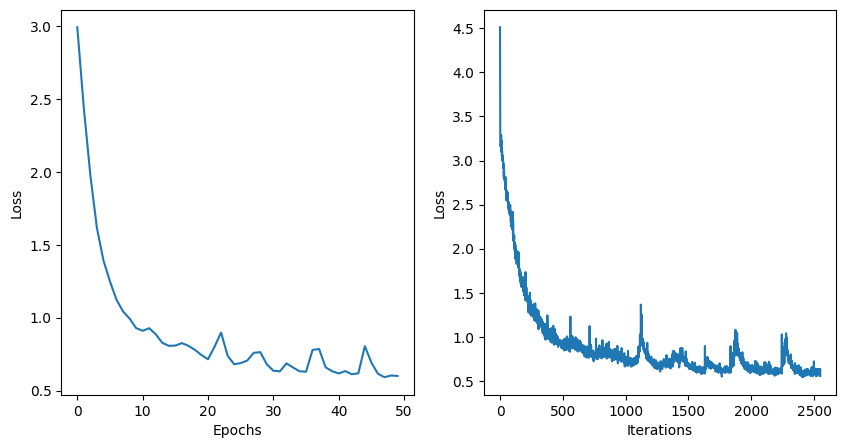

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

In [56]:
ori_path = df_results["image_path"][idx]
ori_image = cv2.imread(ori_path)
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

text_list = []
bboxs = df_results["pred_bbox"][idx]

for bbox in bboxs:
    # Crop Image with Bounding Box
    crop_image = ori_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

    # Convert crop_image to torch tensor
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    image_tensor = transform(crop_image).unsqueeze(0)

 # Replace this with your actual tensor

    # Target size
    target_size = (50, 200)

    # Interpolate the tensor to the target size
    resized_tensor = F.interpolate(image_tensor, size=target_size, mode='bilinear', align_corners=False)

    # Change batch size from 1 to 16
    resized_tensor = resized_tensor.expand(16, -1, -1, -1)

print(resized_tensor.size())    

torch.Size([16, 3, 50, 200])


In [64]:
def get_text_crnn(idx, crnn):
    # Assuming crnn_model is an instance of your CRNN class
    crnn.eval()
    
    ori_path = df_results["image_path"][idx]
    ori_image = cv2.imread(ori_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

    text_list = []
    bboxs = df_results["pred_bbox"][idx]

    for bbox in bboxs:
        # Crop Image with Bounding Box
        crop_image = ori_image[bbox[1]:bbox[3], bbox[0]:bbox[2]]

        # Convert crop_image to torch tensor
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        image_tensor = transform(crop_image).unsqueeze(0)

        target_size = (50, 200)

        # Interpolate the tensor to the target size
        resized_tensor = F.interpolate(image_tensor, size=target_size, mode='bilinear', align_corners=False)

        # Change batch size from 1 to 16
        resized_tensor = resized_tensor.expand(16, -1, -1, -1)

        # Send the image to the specified device
        resized_tensor = resized_tensor.to(device)

        # Perform OCR using CRNN model
        with torch.no_grad():
            preds = crnn(resized_tensor)

        # Convert the predictions to text
        _, preds_index = preds.max(2)
        preds_str = ''.join([chr(preds_index[0][i] + ord('0')) for i in range(preds_index.size(1))])

        # Clean Text
        del_punc_list = [" ", "·", ":", "-"]
        clean_text = re.sub(r"[ ·:-]", "", preds_str)
        clean_text = clean_text.replace("O", "0")
        clean_text = clean_text.replace("I", "1")
        clean_text = clean_text.upper()
        text_list.append(clean_text)

    return text_list

# Use the modified function
# idx = 1  # Replace with the desired index
# text_result = get_text_crnn(idx, crnn_model, device=device)
# print("Recognized Text:", text_result)

In [65]:
idxs = list(np.arange(0, 250))
text_results = tqdm([get_text_crnn(idx,crnn) for idx in idxs])
text_results = [text[0] if len(text)>0 else "" for text in text_results]
df_results["pred_plate_number"] = text_results
df_results

  0%|          | 0/250 [00:00<?, ?it/s]

,image_path,sub,decoded_plate_number,x1_bbox,y1_bbox,x2_bbox,y2_bbox,pred_bbox,confidence,pred_plate_number
0,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,鄂AT2W80,176,497,455,595,"[[177, 493, 454, 597]]",[0.94],1111111111111111
1,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AB967N,213,444,469,551,"[[212, 443, 469, 551]]",[0.94],1111111111111111
2,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A25T29,257,384,525,486,"[[255, 385, 523, 487]]",[0.93],1111111111111111
3,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZW108,201,476,493,570,"[[198, 476, 490, 570]]",[0.93],1111111111111111
4,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AZ2744,252,586,532,684,"[[255, 587, 529, 680]]",[0.95],1111111111111111
...,...,...,...,...,...,...,...,...,...,...
245,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AR8T97,96,584,372,688,"[[95, 584, 372, 687]]",[0.93],1111111111111111
246,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖AL6M60,265,514,533,621,"[[268, 515, 530, 620]]",[0.95],1111111111111111
247,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖A576X9,282,536,566,637,"[[277, 534, 570, 638]]",[0.92],1111111111111111
248,C:/Users/User/DeepLearning/Deep_Learning/final...,ccpd_weather,皖ALF155,64,606,309,723,"[[62, 606, 307, 721]]",[0.94],1111111111111111
